![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    J'ai froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [4]:
import numpy as np

SOS_token = 0
EOS_token = 1
UNK_token = 2
MAX_VOCAB_DIM = 50000
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.default_vocab = {0: "<SOS>", 1: "<EOS>", 2:'<UNK>'}
        self.index2word = self.default_vocab.copy()
        self.n_words = 3 # Count SOS and EOS
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def trim_vocab(self, max_vocab_dim):
        start_idx = len(self.default_vocab)
        kv = np.array([(k,v) for k,v in self.word2count.items() if k not in self.default_vocab])
        sorted_count_idx = np.flip(np.argsort(np.array(kv[:,1], dtype=np.int32)), axis=0)
        self.index2word = self.default_vocab.copy()
        self.word2index = {v:k for k,v in self.index2word.items()}
        i = start_idx
        
        for word in np.array(kv[:,0])[sorted_count_idx[:max_vocab_dim-len(self.default_vocab)]]:
            self.index2word[i] = word
            self.word2index[word] = i
            i += 1
        self.n_words = len(self.index2word)
        self.word2count = {k:v for k,v in self.word2count.items() if k in self.word2index}
            
                
            


### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.strip()
#     print s,'start'
    s = re.sub(u"([.!?])", u" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(u"[^\u4e00-\u9fffa-zA-Z.!?0-9]+", r" ", s)
#     print s,'end'
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [6]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s.decode('utf8')) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [7]:
MAX_LENGTH = 60

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(good_prefixes)
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [14]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

# input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
# input_lang, output_lang, pairs = prepare_data('eng', 'cmn', True)
input_lang, output_lang, pairs = prepare_data('r1', 'r2', True)
input_lang.trim_vocab(MAX_VOCAB_DIM)
output_lang.trim_vocab(MAX_VOCAB_DIM)

# Print an example pair
print(random.choice(pairs))
a,b = random.choice(pairs)
print a
print b

Reading lines...
Read 651339 sentence pairs
Trimmed to 651293 sentence pairs
Indexing words...
[u'SOS \u730e\u6237\u5ea7 \u6709 \u4e00\u628a \u5f13\u7bad EOS r v d v v uj v NOP ian NOE 7 NOR', u'SOS \u4ed6 \u662f\u5426 \u4e5f \u80fd \u770b \u7684 \u89c1 EOS']
SOS 请 爱 我 EOS r a v d v n uj n NOP e NOE 8 NOR
SOS 我 奢望 爱 就 像 吞象 的 蛇 EOS


## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [15]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Positional Encoding

In [16]:
def positional_encoding(d_model, pos):
    assert d_model % 2 == 0
    pos = torch.tensor(pos, dtype=torch.float32, requires_grad=False)
    pe = torch.zeros([1,d_model], dtype=torch.float32, requires_grad=False)
    for i in range(d_model//2):
        a = torch.tensor(10000, dtype=torch.float32, requires_grad=False)
        b = torch.tensor(2.*i/float(d_model), dtype=torch.float32, requires_grad=False)
        c = pos / torch.pow(a, b)
        pe[0, 2*i] = torch.sin(c)
        pe[0, 2*i+1] = torch.cos(c)
    return pe

# Building the models

## The Encoder

<img src="images/encoder-network.png" style="float: right" />

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.d_model = hidden_size
        self.init_pos_mat(MAX_LENGTH*2)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        
        self.embedding = nn.Embedding(input_size, hidden_size)
#         self.linear = nn.Linear(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        embedded = embedded + self.get_pos_mat(seq_len).view(seq_len, 1, -1)
#         embedded = F.relu(self.linear(embedded))
        output, hidden = self.gru(embedded, hidden)
        return embedded, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden
    
    def init_pos_mat(self, cache_length):
        print('init postional matrix with length : %d ' % cache_length)
        self.positional_matrix = torch.cat([positional_encoding(self.d_model, i) for i in range(0,cache_length)], dim=0)
        self.positional_matrix.requires_grad = False
        self.positional_matrix = self.positional_matrix.cuda()
            
        
    def get_pos_mat(self, length):
        if length > self.positional_matrix.shape[0]:
            print('input sequence length reach positional matrix maximum length. %d ' % length)
            ret = torch.cat([positional_encoding(self.d_model, i) for i in range(length)], dim=0)
            ret.requires_grad = False
            print('Increase positional matrix maximum length. %d ' % length)
            self.positional_matrix = ret
            self.positional_matrix = self.positional_matrix.cuda()
            return ret
        else:
            return self.positional_matrix[:length]

In [18]:
encoder_test = EncoderRNN(10, 10, 2)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)
print encoder_outputs.shape

init postional matrix with length : 120 
torch.Size([3, 1, 10])


## Attention Decoder

### Interpreting the Bahdanau et al. model

The attention model in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) is described as the following series of equations.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [19]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies, dim=-1).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
#             print hidden.shape, energy.shape, energy.transpose(0,1).shape, 'lolo'
            energy = torch.mm(hidden,energy.transpose(0,1))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [20]:

class LinearAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(LinearAttnDecoderRNN, self).__init__()
#         
        self.d_model = hidden_size
        self.init_pos_mat(MAX_LENGTH*2)
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
#         self.linear = nn.Linear(hidden_size, hidden_size)
#         self.lin1 = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size * 2 , output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, last_context, last_hidden, encoder_emb, decoder_seq):
        # Get the embedding of the current input word (last output word)
        seq_len, _ = decoder_seq.size()
#         decoder_emb = self.embedding(decoder_seq).view(seq_len, 1, -1)
        decoder_emb = self.embedding(decoder_seq).view(seq_len, 1, -1) + self.get_pos_mat(seq_len).view(seq_len, 1, -1)
#         decoder_emb = F.relu(self.linear(decoder_emb))
        word_embedded = decoder_emb[-1,:].view(1, 1, -1)
        
        seq_embedded = torch.cat([encoder_emb,decoder_emb], dim=0)
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), dim=2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        # Combine embedded input word and last context, run through RNN
#         hidden = F.relu(self.lin1(torch.cat([word_embedded, last_context], 1)))

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), seq_embedded)
        context = attn_weights.bmm(seq_embedded.transpose(0, 1)) # B x 1 x N
        
        word_embedded = word_embedded.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        output = F.log_softmax(self.out(torch.cat([context,word_embedded], dim=-1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights
    
    #     To speed up the positional encoding by construct an cache matrix. 
    def init_pos_mat(self, cache_length):
        print('init postional matrix with length : %d ' % cache_length)
        self.positional_matrix = torch.cat([positional_encoding(self.d_model, i) for i in range(0,cache_length)], dim=0)
        self.positional_matrix.requires_grad = False
        self.positional_matrix = self.positional_matrix.cuda()
            
        
    def get_pos_mat(self, length):
        if length > self.positional_matrix.shape[0]:
            print('input sequence length reach positional matrix maximum length. %d ' % length)
            ret = torch.cat([positional_encoding(self.d_model, i) for i in range(length)], dim=0)
            ret.requires_grad = False
            print('Increase positional matrix maximum length. %d ' % length)
            self.positional_matrix = ret
            self.positional_matrix = self.positional_matrix.cuda()
            return ret
        else:
            return self.positional_matrix[:length]
        

### Testing the models

To make sure the Encoder and Decoder model are working (and working together) we'll do a quick test with fake word inputs:

In [21]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = LinearAttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_embs, encoder_hidden  = encoder_test(word_input, encoder_hidden)
word_inputs = Variable(torch.LongTensor([[1], [2], [3]]))
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(decoder_context, decoder_hidden, encoder_embs, word_inputs)
    next_out = torch.topk(decoder_output, k=1, dim=1)[1]
    word_inputs = torch.cat([word_inputs, next_out], dim=0)
    print(decoder_output.size(), decoder_context.size(), decoder_attn.size(), word_inputs.shape)


init postional matrix with length : 120 
init postional matrix with length : 120 
EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
LinearAttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
(torch.Size([1, 10]), torch.Size([1, 10]), torch.Size([1, 1, 6]), torch.Size([4, 1]))
(torch.Size([1, 10]), torch.Size([1, 10]), torch.Size([1, 1, 7]), torch.Size([5, 1]))
(torch.Size([1, 10]), torch.Size([1, 10]), torch.Size([1, 1, 8]), torch.Size([6, 1]))


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [22]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_embs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = decoder_seq = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
#     decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_seq = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_context, decoder_hidden, encoder_embs, decoder_seq)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input
            decoder_seq = torch.cat([decoder_seq, decoder_input.view(1,1)], dim=0)

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
#             print 'context, embs, seq', decoder_context.shape, encoder_embs.shape, decoder_seq.shape
            
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_context, decoder_hidden, encoder_embs, decoder_seq)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(3)
            for i in range(3):
                ni = topi[0][i]
                if ni != UNK_token:
                    break
        
            decoder_input = Variable(torch.LongTensor([ni])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break
            decoder_seq = torch.cat([decoder_seq, decoder_input.view(1,1)], dim=0)
#     encoder_outputs = torch.cat([encoder_outputs, decoder_rnn_output], dim=0)
    
    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data.item() / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [23]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    if percent == 0:
        es = 0.
    else:
        es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

In [24]:
attn_model = 'general'
hidden_size = 512
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = LinearAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

init postional matrix with length : 120 
init postional matrix with length : 120 


Then set up variables for plotting and tracking progress:

In [25]:
# Configuring training
n_epochs = 500000
plot_every = 20
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [ ]:
from tqdm import tqdm
# Begin!
with tqdm(total=n_epochs + 1) as pbar:
    for epoch in range(1, n_epochs + 1):

        # Get training data for this cycle
        training_pair = variables_from_pair(random.choice(pairs))
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        # Run the train function
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if epoch == 0: continue

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, float(epoch) / n_epochs), epoch, float(epoch) / n_epochs * 100, print_loss_avg)
            print(print_summary)
            evaluate_randomly()

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        pbar.update(1)

  0%|          | 1002/500001 [01:11<11:05:40, 12.49it/s]

1m 56s (- 969m 39s) (1000 0%) 5.4455
> SOS 今晚 这样 下去 EOS m n nr uj NOP e NOE 4 NOR
= SOS 一个 人 安静 的 EOS
< SOS 我 的 EOS <EOS>



  0%|          | 2002/500001 [02:25<10:38:36, 13.00it/s]

3m 11s (- 793m 30s) (2000 0%) 5.5726
> SOS 用 脆弱 的 花蕊 EOS v v v f uj v NOP ei NOE 6 NOR
= SOS 想 抗拒 绽放 后 的 枯萎 EOS
< SOS 我 的 的 的 EOS <EOS>



  1%|          | 3001/500001 [03:41<11:45:55, 11.73it/s]

4m 27s (- 737m 49s) (3000 0%) 5.5620
> SOS 心里 拔 也 拔 不掉 的 一根 刺 EOS m d r v m NOP i NOE 5 NOR
= SOS 一辈子 就 这么 耍赖 一次 EOS
< SOS 我 的 你 的 EOS <EOS>



  1%|          | 4001/500001 [04:55<9:53:14, 13.93it/s] 

5m 41s (- 705m 28s) (4000 0%) 5.4503
> SOS 实现 实现 EOS d v NOP i NOE 2 NOR
= SOS 似曾 相惜 EOS
< SOS 我 EOS <EOS>



  1%|          | 5000/500001 [06:10<11:59:33, 11.47it/s]

6m 56s (- 686m 55s) (5000 1%) 5.3753
> SOS 别人 都 长大 了 EOS d v r m n v p t NOP en NOE 8 NOR
= SOS 只 剩下 我 一个 人 住 在 凌晨 EOS
< SOS 我 的 的 的 EOS <EOS>



  1%|          | 6002/500001 [07:27<11:19:32, 12.12it/s]

8m 13s (- 677m 10s) (6000 1%) 5.4943
> SOS 习惯 的 方式 慵懒 或 放纵 EOS v t uj r d d NOP ian NOE 6 NOR
= SOS 让 过去 的 自己 暂时 先 EOS
< SOS 我 的 你 的 EOS <EOS>



  1%|▏         | 7001/500001 [08:43<10:00:13, 13.69it/s]

9m 28s (- 667m 39s) (7000 1%) 5.3587
> SOS 听 过 天空 拒绝 飞鸟 EOS d v ug r NOP i NOE 4 NOR
= SOS 没 听 过 你 EOS
< SOS 我 的 的 EOS <EOS>



  2%|▏         | 8002/500001 [09:58<9:38:38, 14.17it/s] 

10m 43s (- 659m 49s) (8000 1%) 5.3748
> SOS 等待 愈 浓郁 神化 的 约会 EOS n n r a NOP i NOE 4 NOR
= SOS 意象 色彩 多麼 精致 EOS
< SOS 我 的 的 的 EOS <EOS>



  2%|▏         | 9001/500001 [11:14<11:07:10, 12.27it/s]

12m 0s (- 655m 5s) (9000 1%) 5.5272
> SOS 笑 我 太 不 值得 EOS p v m a NOP ong NOE 4 NOR
= SOS 为了 换取 一点点 虚荣 EOS
< SOS 你 的 的 EOS <EOS>



  2%|▏         | 10002/500001 [12:31<9:05:17, 14.98it/s]

13m 17s (- 651m 19s) (10000 2%) 5.4384
> SOS 明天 起 开始 学习 EOS m n uj n d v r NOP i NOE 7 NOR
= SOS 一个 人 的 世界 不再 需要 你 EOS
< SOS 我 的 你 EOS <EOS>



  2%|▏         | 11001/500001 [13:47<10:43:49, 12.66it/s]

14m 33s (- 647m 11s) (11000 2%) 5.4617
> SOS 时间 从不 停歇 EOS v r t NOP ian NOE 3 NOR
= SOS 催促 我们 向前 EOS
< SOS 我 EOS <EOS>



  2%|▏         | 12001/500001 [15:04<10:33:22, 12.84it/s]

15m 49s (- 643m 50s) (12000 2%) 5.4447
> SOS 虽然 雨 的 步态 转 柔 EOS c r d v r a uj v uz n n uj n NOP in NOE 13 NOR
= SOS 但是 你 仍然 听见 它 清朗 的 带 着 金属 韵律 的 步音 EOS
< SOS 我 的 你 的 的 的 的 EOS <EOS>



  3%|▎         | 13001/500001 [16:19<10:03:03, 13.46it/s]

17m 5s (- 640m 11s) (13000 2%) 5.5180
> SOS 后悔 告诉 你 价钱 EOS r v v d v y NOP a NOE 6 NOR
= SOS 你 欢喜 吃 就 吃 啦 EOS
< SOS 我 的 的 EOS <EOS>



  3%|▎         | 14002/500001 [17:33<8:48:59, 15.31it/s] 

18m 19s (- 636m 10s) (14000 2%) 5.2961
> SOS 见招拆招 时间 不 早 EOS m n n d r d a NOP ao NOE 7 NOR
= SOS 两 人 行程 约 哪里 才 好 EOS
< SOS 我 的 的 <EOS>



  3%|▎         | 15001/500001 [18:46<8:38:23, 15.59it/s] 

19m 32s (- 631m 49s) (15000 3%) 5.1425
> SOS 鹰 显然 是 想 挣扎 着 重返 蓝天 EOS d NOP u NOE 1 NOR
= SOS 欲 EOS
< SOS 我 的 EOS <EOS>



  3%|▎         | 16001/500001 [19:58<9:41:10, 13.88it/s] 

20m 44s (- 627m 14s) (16000 3%) 5.0384
> SOS 後 悔 時 的 淚水 又 特別 讓 人 覺得 無力 疲憊 EOS a v d v a r v c r v ul r NOP ui NOE 12 NOR
= SOS 舊 愛 還 是 最美 有時 分手 不是 誰 負 了 誰 EOS
< SOS 我 的 的 的 EOS <EOS>



  3%|▎         | 17001/500001 [21:10<10:37:11, 12.63it/s]

21m 56s (- 623m 23s) (17000 3%) 5.0506
> SOS 会 不会 随 落叶 变得 腐朽 EOS v c d v NOP ou NOE 4 NOR
= SOS 放手 或 不 放手 EOS
< SOS 我 的 EOS <EOS>



  4%|▎         | 18002/500001 [22:22<9:54:23, 13.52it/s] 

23m 7s (- 619m 22s) (18000 3%) 5.0981
> SOS 我 只 想 为 你 再 努力 一点 EOS r v p n uj n p nr NOP ian NOE 8 NOR
= SOS 我 要 把 梦想 的 歌唱 给 蓝天 EOS
< SOS 我 的 你 EOS <EOS>



  4%|▍         | 19002/500001 [23:33<8:19:52, 16.04it/s] 

24m 18s (- 615m 26s) (19000 3%) 5.0431
> SOS 只有 我 深爱 的 这 季节 听到 EOS r n v v uj n NOP in NOE 6 NOR
= SOS 我 泪水 涌出 划落 的 声音 EOS
< SOS 我 的 EOS <EOS>



  4%|▍         | 20001/500001 [24:44<8:56:12, 14.92it/s] 

25m 30s (- 612m 2s) (20000 4%) 4.9986
> SOS 数落 我 改不掉 习惯 怎么办 EOS t f m NOP iao NOE 3 NOR
= SOS 明明 上 一秒 EOS
< SOS 我 的 EOS <EOS>



  4%|▍         | 21002/500001 [25:55<9:20:05, 14.25it/s] 

26m 41s (- 608m 49s) (21000 4%) 5.0133
> SOS 他 几乎 全用 在 自费 进修 英语 和 买 书上 EOS nr v v NOP ao NOE 3 NOR
= SOS 杜厦 留心 到 EOS
< SOS 我 的 的 的 EOS <EOS>



  4%|▍         | 22001/500001 [27:08<10:21:44, 12.81it/s]

27m 54s (- 606m 14s) (22000 4%) 5.1688
> SOS 当再 经过 雪路 已 找 不到 EOS t r c uj n NOP i NOE 5 NOR
= SOS 旧日 那 无言 的 女子 EOS
< SOS 我 的 EOS <EOS>



  5%|▍         | 23001/500001 [28:22<11:15:32, 11.77it/s]

29m 7s (- 604m 8s) (23000 4%) 5.2522
> SOS 满海 飘荡 找 不到 岸 EOS r ns zg v NOP ang NOE 4 NOR
= SOS 这 夕阳 仍 盼望 EOS
< SOS 我 的 的 EOS <EOS>



  5%|▍         | 24001/500001 [29:35<10:23:56, 12.72it/s]

30m 20s (- 601m 49s) (24000 4%) 5.2216
> SOS 青春 伴 着 青涩 EOS v NOP e NOE 1 NOR
= SOS 合 EOS
< SOS 我 的 EOS <EOS>



  5%|▌         | 25003/500001 [30:47<9:46:10, 13.51it/s] 

31m 33s (- 599m 31s) (25000 5%) 5.1629
> SOS 是 你 抚养 我 长大 EOS v r v m n NOP ua NOE 5 NOR
= SOS 陪 我 说 第一句 话 EOS
< SOS 我 的 EOS <EOS>



  5%|▌         | 26001/500001 [31:59<9:04:21, 14.51it/s] 

32m 44s (- 596m 58s) (26000 5%) 5.1222
> SOS 月亮 吗 出来 呀 照照 你 脸上 EOS e e y e NOP ai NOE 4 NOR
= SOS 哎呀 嘿 呀 哎 EOS
< SOS 我 的 的 的 EOS <EOS>



  5%|▌         | 27001/500001 [33:12<9:35:14, 13.70it/s] 

33m 58s (- 595m 4s) (27000 5%) 5.2615
> SOS 我们 走 在 这条 漫长 的 路上 EOS i f uj n NOP u NOE 4 NOR
= SOS 真不知道 前方 的 路 EOS
< SOS 我 的 你 EOS <EOS>



  6%|▌         | 28003/500001 [34:24<9:27:20, 13.87it/s] 

35m 10s (- 592m 55s) (28000 5%) 5.1590
> SOS 光 透过 玻璃窗 氤氲 在 脸上 EOS r n v uz r v r v uj n NOP ang NOE 10 NOR
= SOS 那 光影 带 着 我 走向 你 沉醉 的 脸庞 EOS
< SOS 我 的 的 EOS <EOS>



  6%|▌         | 29001/500001 [35:36<8:43:03, 15.01it/s] 

36m 22s (- 590m 46s) (29000 5%) 5.1196
> SOS 我们 虽 不 在 同一个 地方 EOS v d uj n NOP ang NOE 4 NOR
= SOS 没有 相同 的 主张 EOS
< SOS 我 的 的 EOS <EOS>



  6%|▌         | 30002/500001 [36:48<9:16:02, 14.09it/s] 

37m 34s (- 588m 33s) (30000 6%) 5.1031
> SOS 心中 爱 你 的 那 盏灯 EOS p l d p r v NOP ie NOE 6 NOR
= SOS 在 无意间 已 被 你 浇灭 EOS
< SOS 我 的 的 EOS <EOS>



  6%|▌         | 31002/500001 [37:59<10:19:06, 12.63it/s]

38m 45s (- 586m 20s) (31000 6%) 5.0582
> SOS 也许 该 找 个 朋友 像 你 一样 不停 的 吵闹 EOS r r v v NOP ao NOE 4 NOR
= SOS 为何 我 拼命 寻找 EOS
< SOS 我 的 你 的 的 EOS <EOS>



  6%|▋         | 32001/500001 [39:10<10:30:19, 12.37it/s]

39m 56s (- 584m 10s) (32000 6%) 5.0615
> SOS 努力 了 一阵 EOS d a uv v v NOP ou NOE 5 NOR
= SOS 终于 疲乏 地 垂 下头 EOS
< SOS 我 的 EOS <EOS>



  7%|▋         | 33002/500001 [40:24<9:19:05, 13.92it/s] 

41m 9s (- 582m 31s) (33000 6%) 5.1788
> SOS 她 更 迷惑 了 EOS d v v f uj v n v n v ns c n NOP i NOE 13 NOR
= SOS 不 知道 爱 上 的 是 雪景 是 诗词 是 中国 还是 男子 EOS
< SOS 我 的 EOS <EOS>



  7%|▋         | 34001/500001 [41:35<9:44:45, 13.28it/s] 

42m 21s (- 580m 30s) (34000 6%) 4.9310
> SOS 该 走 了 曾经 属于 我 的 情绪 竟然 都 失控 EOS d v v ul NOP e NOE 4 NOR
= SOS 不得不 结束 了忘 了 EOS
< SOS 我 我 的 的 的 的 <EOS>



  7%|▋         | 35002/500001 [42:49<8:06:07, 15.94it/s] 

43m 34s (- 579m 0s) (35000 7%) 5.2163
> SOS 上网 也 混混 EOS v d v NOP un NOE 3 NOR
= SOS 上床 也 混 EOS
< SOS 我 的 EOS <EOS>



  7%|▋         | 36002/500001 [44:01<9:05:50, 14.17it/s] 

44m 47s (- 577m 17s) (36000 7%) 5.1427
> SOS 每个 月 她 总会 有 那么 几天 EOS r v v n r d v v NOP an NOE 8 NOR
= SOS 我 不能 有 杂念 什么 都 不能 干 EOS
< SOS 我 的 的 的 EOS <EOS>



  7%|▋         | 37001/500001 [45:14<8:16:06, 15.55it/s] 

46m 0s (- 575m 41s) (37000 7%) 5.0916
> SOS 我 知 过分 中意 枉 捉 错用 神 EOS v r d nr d yg q NOP en NOE 7 NOR
= SOS 明知 你 最 後 亦 冇 份 EOS
< SOS 我 的 EOS <EOS>



  8%|▊         | 38001/500001 [46:27<9:30:58, 13.49it/s] 

47m 12s (- 573m 59s) (38000 7%) 5.0973
> SOS 我 梦见 我 穿堂 过 巷地 在 巴黎 EOS r p nr v ul nr n NOP ing NOE 7 NOR
= SOS 我 在 香榭丽舍 买 了 蓝 风铃 EOS
< SOS 我 的 的 的 EOS <EOS>



  8%|▊         | 39002/500001 [47:40<10:51:03, 11.80it/s]

48m 25s (- 572m 26s) (39000 7%) 5.0658
> SOS 收割 我 的 爱 EOS z n d v t NOP ai NOE 5 NOR
= SOS 鲜红 镰刀 正 挥舞 下来 EOS
< SOS 我 的 EOS <EOS>



  8%|▊         | 40002/500001 [48:54<9:52:41, 12.94it/s] 

49m 40s (- 571m 11s) (40000 8%) 5.0990
> SOS 我 真的 好 想 找 一条 船 EOS v d v r q nr NOP an NOE 6 NOR
= SOS 能 远远 离开 这 片 沙滩 EOS
< SOS 我 我 的 EOS <EOS>



  8%|▊         | 41002/500001 [50:09<9:40:55, 13.17it/s] 

50m 54s (- 569m 59s) (41000 8%) 5.1421
> SOS 少林寺 美丽 辉煌 EOS m uj ns NOP i NOE 3 NOR
= SOS 千年 的 古寺 EOS
< SOS 我 的 的 EOS <EOS>



  8%|▊         | 42001/500001 [51:22<9:15:52, 13.73it/s] 

52m 8s (- 568m 32s) (42000 8%) 4.9880
> SOS 学到 足 关帝 座镇 华容 EOS v a ng v v n NOP ong NOE 6 NOR
= SOS 恨 满 胸 裹 蒸 粽 EOS
< SOS 我 的 我 EOS <EOS>



  9%|▊         | 43001/500001 [52:34<9:57:49, 12.74it/s] 

53m 20s (- 566m 50s) (43000 8%) 5.0114
> SOS 片片 回忆 活下去 EOS r n z n v NOP u NOE 5 NOR
= SOS 任 时光 匆匆 流 去 EOS
< SOS 你 的 EOS <EOS>



  9%|▉         | 44002/500001 [53:46<9:15:38, 13.68it/s] 

54m 32s (- 565m 11s) (44000 8%) 5.0146
> SOS 一整夜 站立 在 窗口 EOS v v r i v r NOP o NOE 6 NOR
= SOS 还好 有 这 万家灯火 陪 我 EOS
< SOS 我 的 的 EOS <EOS>



  9%|▉         | 45002/500001 [55:01<8:35:05, 14.72it/s] 

55m 46s (- 563m 59s) (45000 9%) 5.0982
> SOS 不是 我 跟 你 EOS n a NOP iao NOE 2 NOR
= SOS 俗尘 渺渺 EOS
< SOS 我 的 EOS <EOS>



  9%|▉         | 46002/500001 [56:14<9:40:41, 13.03it/s] 

57m 0s (- 562m 39s) (46000 9%) 5.1398
> SOS 话到嘴边 又 咽下 EOS n r v p r v NOP iao NOE 6 NOR
= SOS 妈妈 我 想 对 您 笑 EOS
< SOS 我 的 EOS <EOS>



  9%|▉         | 47001/500001 [57:26<8:53:54, 14.14it/s] 

58m 11s (- 560m 54s) (47000 9%) 4.8779
> SOS 你们 在 哪里 我 的 朋友 兄弟 EOS ns uj n v v r NOP i NOE 6 NOR
= SOS 四海 的 朋友 感谢 有 你 EOS
< SOS 我 的 的 的 EOS <EOS>



 10%|▉         | 48003/500001 [58:37<8:12:41, 15.29it/s] 

59m 23s (- 559m 12s) (48000 9%) 4.9694
> SOS 害怕 的 你 不用 担心 我 哪里 都 不会 去 EOS v r uj v an uz r v r s NOP in NOE 10 NOR
= SOS 没有 任何 的 委屈 温暖 着 你 直到 你 心 EOS
< SOS 我 的 我 的 EOS <EOS>



 10%|▉         | 49002/500001 [59:48<9:25:32, 13.29it/s] 

60m 34s (- 557m 31s) (49000 9%) 5.0264
> SOS 慈母 手中 线 游子 身上 衣 EOS v n a d v NOP ui NOE 5 NOR
= SOS 临行 密密缝 意恐 迟迟 归 EOS
< SOS 我 的 我 的 EOS <EOS>



 10%|▉         | 49999/500001 [1:01:00<8:26:28, 14.81it/s] 

61m 45s (- 555m 52s) (50000 10%) 5.0203
> SOS 年轻 的 朋友 用 你 的 勇气 回答 我 EOS nr f s uj n d v v r NOP e NOE 9 NOR
= SOS 阳光 下 心里 的 歌唱 不 出来 是 为什么 EOS
< SOS 我 的 你 的 EOS <EOS>



 10%|█         | 51002/500001 [1:02:13<8:58:55, 13.89it/s] 

62m 59s (- 554m 30s) (51000 10%) 5.0691
> SOS 和 飘香 的 烟 EOS r t d v r m NOP ian NOE 6 NOR
= SOS 每个 星期 都 盼望 这 一天 EOS
< SOS 我 的 EOS <EOS>



 10%|█         | 52001/500001 [1:03:25<8:59:13, 13.85it/s] 

64m 10s (- 552m 55s) (52000 10%) 4.9947
> SOS 两 人 愿意 没 惆怅 EOS m n an v d n n p d NOP iang NOE 9 NOR
= SOS 三 人 痛苦 恋爱 不再 问 事实 与 真相 EOS
< SOS 我 的 EOS <EOS>



 11%|█         | 53001/500001 [1:04:36<8:59:54, 13.80it/s] 

65m 22s (- 551m 22s) (53000 10%) 4.9895
> SOS 鲜活 的 人呐 EOS d n c a NOP i NOE 4 NOR
= SOS 从未 情欲 而 得体 EOS
< SOS 我 的 EOS <EOS>



 11%|█         | 54001/500001 [1:05:47<9:52:42, 12.54it/s] 

66m 33s (- 549m 43s) (54000 10%) 5.0043
> SOS 你 靠 在 我 的 肩 你 的 笑 那么 甜 EOS d d ug ul m m NOP ian NOE 6 NOR
= SOS 仿佛 已 过 了 好多好多 年 EOS
< SOS 我 你 的 的 的 EOS <EOS>



 11%|█         | 55001/500001 [1:07:04<10:14:06, 12.08it/s]

67m 49s (- 548m 49s) (55000 11%) 5.3808
> SOS 让 往事 像 雾气 慢慢 地 蒸发 EOS v nr d d v f NOP ia NOE 6 NOR
= SOS 等到 麻木 也许 就 放得 下 EOS
< SOS 我 的 的 的 的 EOS <EOS>



 11%|█         | 56002/500001 [1:08:20<9:52:05, 12.50it/s] 

69m 5s (- 547m 51s) (56000 11%) 5.4027
> SOS 突然 好想你 EOS ad a uj v NOP i NOE 4 NOR
= SOS 突然 锋利 的 回忆 EOS
< SOS 我 EOS <EOS>



 11%|█▏        | 57001/500001 [1:09:35<9:30:06, 12.95it/s] 

70m 20s (- 546m 45s) (57000 11%) 5.3789
> SOS 萨嘎 拉 贝勒 佳纳 EOS d nrt ns NOP a NOE 3 NOR
= SOS 尤 哈拉 佳雅达他嘎达雅 EOS
< SOS 我 的 EOS <EOS>



 12%|█▏        | 58001/500001 [1:10:52<9:40:33, 12.69it/s] 

71m 37s (- 545m 52s) (58000 11%) 5.3189
> SOS 只 想 把 你 抱进 我 胸怀 EOS t d v v NOP ai NOE 4 NOR
= SOS 夏天 就是 要 恋爱 EOS
< SOS 我 的 的 EOS <EOS>



 12%|█▏        | 59001/500001 [1:12:08<9:12:23, 13.31it/s] 

72m 53s (- 544m 52s) (59000 11%) 5.3638
> SOS 这 绿岛 像 一只 船 EOS p m t v y v NOP ao NOE 6 NOR
= SOS 在 月 夜里 摇 啊 摇 EOS
< SOS 我 的 的 的 EOS <EOS>



 12%|█▏        | 60001/500001 [1:13:23<9:26:53, 12.94it/s] 

74m 9s (- 543m 47s) (60000 12%) 5.3519
> SOS 为 祖国 贡献 出 青春 和 力量 EOS nr zg NOP a NOE 2 NOR
= SOS 啊啊啊 啊 EOS
< SOS 我 的 的 EOS <EOS>



 12%|█▏        | 61002/500001 [1:14:40<8:34:16, 14.23it/s] 

75m 26s (- 542m 55s) (61000 12%) 5.3869
> SOS 为什么 又 是 下 一个 路口 EOS c r d v NOP ou NOE 4 NOR
= SOS 但是 我们 依然 牵着手 EOS
< SOS 我 的 的 EOS <EOS>



 12%|█▏        | 62001/500001 [1:15:56<9:08:01, 13.32it/s] 

76m 42s (- 541m 53s) (62000 12%) 5.3803
> SOS 俯身 向 大地 背 朝着 蓝天 EOS s n uj n y r d uj n NOP ian NOE 9 NOR
= SOS 心中 点点 的 云 啊 我 默默 的 念 EOS
< SOS 我 你 的 的 的 EOS <EOS>



 13%|█▎        | 63000/500001 [1:17:12<9:58:47, 12.16it/s] 

77m 58s (- 540m 50s) (63000 12%) 5.3711
> SOS 我 不要 只是 你 的 小 木偶 EOS r r q r p r v NOP ong NOE 7 NOR
= SOS 每天 每 分 每秒 被 你 操纵 EOS
< SOS 我 我 的 的 的 EOS <EOS>



 13%|█▎        | 64001/500001 [1:18:29<8:51:24, 13.67it/s] 

79m 15s (- 539m 56s) (64000 12%) 5.3166
> SOS 两个 人 的 一座 城 EOS r p ns r p ns NOP ong NOE 6 NOR
= SOS 你 在 城西 他 在 城东 EOS
< SOS 我 的 我 的 EOS <EOS>



 13%|█▎        | 65001/500001 [1:19:45<9:07:28, 13.24it/s] 

80m 30s (- 538m 48s) (65000 13%) 5.3185
> SOS 一 是 婴儿 哭啼 二 是 学 游戏 EOS m v ns n m v d v r NOP i NOE 9 NOR
= SOS 三 是 青春 物语 四 是 碰巧 遇见 你 EOS
< SOS 我 我 我 的 的 的 EOS <EOS>



 13%|█▎        | 66001/500001 [1:21:01<9:41:04, 12.45it/s] 

81m 47s (- 537m 48s) (66000 13%) 5.3354
> SOS 有 一天 你 会 懂得 怎么样 去 忘记 他 EOS r v v v r uj n y NOP a NOE 8 NOR
= SOS 你 会 遇到 爱 你 的 人 啊 EOS
< SOS 我 的 你 的 的 的 的 EOS <EOS>



 13%|█▎        | 67002/500001 [1:22:18<9:43:25, 12.37it/s] 

83m 4s (- 536m 50s) (67000 13%) 5.4196
> SOS 喜欢 你 说不出口 EOS a v p r v NOP ai NOE 5 NOR
= SOS 好 想 跟 你 表白 EOS
< SOS 我 的 的 EOS <EOS>



 14%|█▎        | 68001/500001 [1:23:35<10:10:23, 11.80it/s]

84m 20s (- 535m 51s) (68000 13%) 5.2939
> SOS 点燃 EOS a uj n NOP eng NOE 3 NOR
= SOS 潮湿 的 风 EOS
< SOS 我 EOS <EOS>



 14%|█▍        | 69002/500001 [1:24:51<8:28:16, 14.13it/s] 

85m 37s (- 534m 47s) (69000 13%) 5.3063
> SOS 有 办法 没 出轨 先 怨 后悔 EOS d v r r v r v a NOP ei NOE 8 NOR
= SOS 都 是 谁 你 怪 他 看 般配 EOS
< SOS 我 的 你 的 你 EOS <EOS>



 14%|█▍        | 70002/500001 [1:26:07<10:12:21, 11.70it/s]

86m 53s (- 533m 43s) (70000 14%) 5.3098
> SOS 海边 的 晚风 吹 EOS v v r v NOP ui NOE 4 NOR
= SOS 好像 是 你 相随 EOS
< SOS 我 的 的 EOS <EOS>



 14%|█▍        | 71000/500001 [1:27:23<8:57:22, 13.31it/s] 

88m 8s (- 532m 36s) (71000 14%) 5.2632
> SOS 下课铃 狂响 只有 先生 慢动作 EOS n v uz v n uj n NOP e NOE 7 NOR
= SOS 苹果 忙 着 配合 离心力 的 守则 EOS
< SOS 我 的 的 的 的 EOS <EOS>



 14%|█▍        | 72002/500001 [1:28:38<8:42:09, 13.66it/s] 

89m 24s (- 531m 27s) (72000 14%) 5.2333
> SOS 那 是 说书 人口 中 海市蜃楼 EOS nrt NOP an NOE 1 NOR
= SOS 特曼 EOS
< SOS 我 的 EOS <EOS>



 15%|█▍        | 73001/500001 [1:29:55<10:17:44, 11.52it/s]

90m 40s (- 530m 24s) (73000 14%) 5.3715
> SOS 献给 有 梦 的 嗯 嘛 EOS r n a e y e y e y y NOP a NOE 10 NOR
= SOS 我 嘴唇 温热 嗯 嘛 嗯 嘛 嗯 嘛 嘛 EOS
< SOS 你 的 你 的 的 的 EOS <EOS>



 15%|█▍        | 74002/500001 [1:31:11<8:54:48, 13.28it/s] 

91m 56s (- 529m 19s) (74000 14%) 5.3043
> SOS 离开 的 理由 我 只 需要 一个 EOS c f v v m m d v c p r NOP i NOE 11 NOR
= SOS 无论 以后 会 有 多少 个 不 舍 但是 为 你 EOS
< SOS 我 的 你 的 你 的 EOS <EOS>



 15%|█▍        | 75000/500001 [1:32:29<9:46:04, 12.09it/s] 

93m 15s (- 528m 25s) (75000 15%) 5.3302
> SOS 我 交给 你 你 一起 EOS n v a n NOP i NOE 4 NOR
= SOS 收腹 兼 挺挺 胸肌 EOS
< SOS 我 的 的 EOS <EOS>



 15%|█▌        | 76002/500001 [1:33:47<9:07:56, 12.90it/s] 

94m 32s (- 527m 28s) (76000 15%) 5.3161
> SOS 经过 一排排 凋零 的 树 EOS v ns c a NOP u NOE 4 NOR
= SOS 还有 青春 和 孤独 EOS
< SOS 我 的 的 EOS <EOS>



 15%|█▌        | 77001/500001 [1:35:03<9:40:37, 12.14it/s] 

95m 48s (- 526m 21s) (77000 15%) 5.3401
> SOS 我 的 鼻梁 已经 被 晒伤 我 的 头皮 也 开始 发烫 EOS r v r n z n d mq v f uj a n NOP ie NOE 13 NOR
= SOS 我 爱 这 油箱 满满的 感觉 随时 一脚 甩掉 身后 的 烦恼 世界 EOS
< SOS 我 你 的 你 的 的 的 的 <EOS>



 16%|█▌        | 78002/500001 [1:36:20<13:46:23,  8.51it/s]

97m 6s (- 525m 22s) (78000 15%) 5.2215
> SOS 等待 谢幕 的 掌声 EOS m n v uz n NOP in NOE 5 NOR
= SOS 第九号 协奏曲 吟唱 着 伤心 EOS
< SOS 我 的 的 EOS <EOS>



 16%|█▌        | 79002/500001 [1:37:36<8:32:29, 13.69it/s] 

98m 21s (- 524m 11s) (79000 15%) 5.2674
> SOS 不禁 要 承认 我 EOS v t r v uj n NOP en NOE 6 NOR
= SOS 像 往日 我 恨透 的 罪人 EOS
< SOS 我 的 的 的 EOS <EOS>



 16%|█▌        | 80001/500001 [1:38:51<8:23:59, 13.89it/s] 

99m 37s (- 523m 1s) (80000 16%) 5.3104
> SOS 后者 是 一位 饱经沧桑 的 艺术家 发自 心灵 的 叹息 EOS d v nr NOP e NOE 3 NOR
= SOS 都 是 莫扎特 EOS
< SOS 我 的 的 的 EOS <EOS>



 16%|█▌        | 81001/500001 [1:40:07<9:20:47, 12.45it/s] 

100m 52s (- 521m 50s) (81000 16%) 5.1889
> SOS 蓝蓝的 夜 蓝蓝的 梦 EOS v r p r uj n f v v NOP ai NOE 9 NOR
= SOS 请 你 从 我 的 梦 中 走 出来 EOS
< SOS 我 在 等 你 的 EOS <EOS>



 16%|█▋        | 82002/500001 [1:41:23<9:16:16, 12.52it/s] 

102m 8s (- 520m 41s) (82000 16%) 5.2994
> SOS 听 那 风声 听 那 雨声 你 的 歌声 EOS r v uj m ns a v NOP en NOE 7 NOR
= SOS 我们 轮回 的 一生 新旧 难 分 EOS
< SOS 我 是 我 的 的 EOS <EOS>



 17%|█▋        | 83001/500001 [1:42:38<9:34:41, 12.09it/s] 

103m 24s (- 519m 32s) (83000 16%) 5.3122
> SOS 都 爱 过 有 的 人 爱 的 像是 一个 观众 EOS d n uj n n d v NOP ong NOE 7 NOR
= SOS 最 基本 的 感情 戏 也 看不懂 EOS
< SOS 我 的 的 的 的 的 的 的 EOS <EOS>



 17%|█▋        | 84001/500001 [1:43:55<10:06:23, 11.43it/s]

104m 40s (- 518m 24s) (84000 16%) 5.3479
> SOS 失去 多久 才 够 接受 爱 的 残酷 EOS r r v v ul r n NOP u NOE 7 NOR
= SOS 为何 你 要 放弃 了 这 全部 EOS
< SOS 我 的 你 的 你 的 EOS <EOS>



 17%|█▋        | 85001/500001 [1:45:12<9:57:50, 11.57it/s] 

105m 57s (- 517m 21s) (85000 17%) 5.2676
> SOS 我会 把 心情 整理 一遍 EOS t n v v d a NOP uan NOE 6 NOR
= SOS 明天 用心 去 想 就 遥远 EOS
< SOS 我 的 我 的 EOS <EOS>



 17%|█▋        | 87002/500001 [1:47:45<7:49:18, 14.67it/s] 

108m 31s (- 515m 10s) (87000 17%) 5.3484
> SOS 叩 叩 EOS vg vg vg vg NOP ou NOE 4 NOR
= SOS 叩 叩 叩 叩 EOS
< SOS 我 EOS <EOS>



 18%|█▊        | 88002/500001 [1:49:03<9:39:11, 11.86it/s] 

109m 48s (- 514m 6s) (88000 17%) 5.2489
> SOS 向 快乐 出发 别 害怕 EOS a d v s a uj n NOP ia NOE 7 NOR
= SOS 幸福 就 像 天边 灿烂 的 晚霞 EOS
< SOS 我 你 的 的 EOS <EOS>



 18%|█▊        | 89002/500001 [1:50:19<8:34:42, 13.31it/s] 

111m 4s (- 512m 57s) (89000 17%) 5.3506
> SOS 这 一年 夏天 有 最 温暖 的 目光 EOS n uj s r v uj nr NOP uang NOE 7 NOR
= SOS 记忆 的 远方 我 披戴 的 荣光 EOS
< SOS 我 的 我 的 的 EOS EOS <EOS>



 18%|█▊        | 90001/500001 [1:51:36<8:39:00, 13.17it/s] 

112m 22s (- 511m 53s) (90000 18%) 5.2737
> SOS 不 知道 你 是不是 在乎 EOS a v p m v n NOP u NOE 6 NOR
= SOS 明 知道 在 一起 是 错误 EOS
< SOS 我 的 的 的 EOS <EOS>



 18%|█▊        | 92001/500001 [1:54:34<11:52:29,  9.54it/s]

115m 20s (- 511m 29s) (92000 18%) 5.2383
> SOS 是 你 的 体贴 让 我 再次 热烈 EOS v r uj m a vn n NOP ue NOE 7 NOR
= SOS 是 你 的 万种 柔情 融化 冰雪 EOS
< SOS 我 的 的 的 的 的 EOS <EOS>



 19%|█▊        | 93002/500001 [1:56:04<10:10:18, 11.11it/s]

116m 50s (- 511m 18s) (93000 18%) 5.2909
> SOS 今天 又 不见 EOS d v v NOP ian NOE 3 NOR
= SOS 只 剩下 怀念 EOS
< SOS 我 EOS <EOS>



 19%|█▉        | 94001/500001 [1:57:34<10:50:43, 10.40it/s]

118m 20s (- 511m 6s) (94000 18%) 5.3103
> SOS 梦醒 推门 他 依旧 不 在 EOS v n n r n ns NOP iang NOE 6 NOR
= SOS 闻 茶香 思念 那 油菜花 香 EOS
< SOS 我 的 的 的 的 EOS <EOS>



 19%|█▉        | 94089/500001 [1:57:41<8:29:30, 13.28it/s] 

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

In [105]:
# torch.save(encoder,'./models/encoder-linear.pl')
# torch.save(decoder,'./models/decoder-linear.pl')

In [97]:
# encoder = torch.load('./models/encoder-linear.pl')
# decoder = torch.load('./models/decoder-linear.pl')


<Figure size 432x288 with 0 Axes>

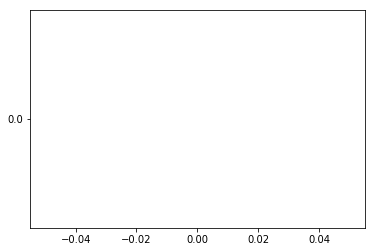

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [27]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_embs, encoder_hidden  = encoder(input_variable.cuda(), encoder_hidden.cuda())

    # Create starting vectors for decoder
    decoder_input = decoder_seq = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_seq = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, 2*max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_context, decoder_hidden, encoder_embs, decoder_seq)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(3)
        for i in range(3):
            ni = topi[0][i]
            if ni != UNK_token:
                break
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
        decoder_seq = torch.cat([decoder_seq, decoder_input], dim=0)
        
    return decoded_words, decoder_attentions[:di+1, :len(encoder_embs)+di+1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [28]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    
#     print('>', pair[0])
#     print('=', pair[1])
#     print('<', output_sentence)
#     print('')
    print '>', pair[0]
    print '=', pair[1]
    print '<', output_sentence
    print ''

In [29]:
evaluate_randomly()

> SOS 你 总 流连 在 我 脑海 EOS v r v v NOP ai NOE 4 NOR
= SOS 眷恋 你 恋成 依赖 EOS
< 搭建 大好河山 受不起 尽而 多位 配有 夜未央 造物 右脑 物资 旧地 共同 估 弹断 下世纪 奇花异草 轉過 缘何 必需品 名堂 内个 拼夜 纤夫 引诱 躲不开 旧地 共同 右脑 第几 油菜花 待风 八朵 那丽桑 先验 见招拆招 浪接浪 螳螂 守恒 诃 会晤 看得出来 香露 滴滴 同行者 沙丘 二分之一 迦罗帝夷 看轻 青筋 旧地 炮弹 不矜不伐 制胜 不矜不伐 制胜 北岛 路有平 自怨 要诀 明显



# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

6 torch.Size([6, 21])


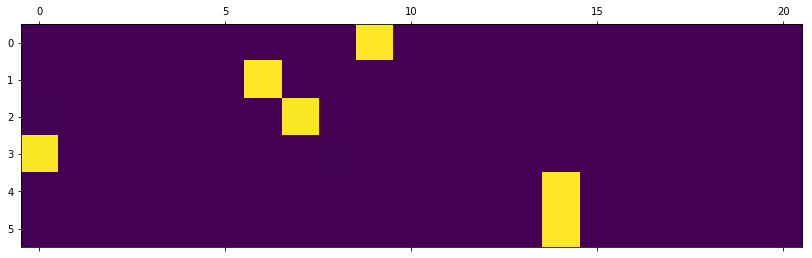

In [113]:
output_words, attentions = evaluate(u"SOS 所以 我 好 愿意 EOS v r l NOP i NOE 3 NOR")
print len(output_words), attentions.shape
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [138]:
import matplotlib
zhfont = matplotlib.font_manager.FontProperties(fname="/home/k123/simhei.ttf")
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'] + output_words, rotation=90, fontproperties=zhfont)
    ax.set_yticklabels([''] + output_words, fontproperties=zhfont)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print 'input =', input_sentence
    print 'output =', ' '.join(output_words)
    print attentions.shape
    show_attention(input_sentence, output_words, attentions)


input = SOS 男 我 的 爱 EOS b r uj n NOP ai NOE 4 NOR
output = SOS 女 我 的 爱 EOS <EOS>
torch.Size([7, 23])


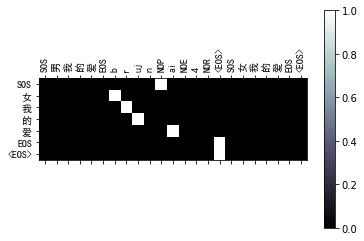

In [139]:
pair = random.choice(pairs)
evaluate_and_show_attention(pair[0])

input = elle a cinq ans de moins que moi .
output = SOS 下 个 上 中 谁 能 EOS <EOS>
torch.Size([9, 19])


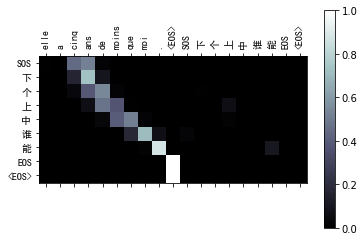

In [128]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

In [ ]:
evaluate_and_show_attention("elle est trop petit .")

In [ ]:
evaluate_and_show_attention("je ne crains pas de mourir .")

In [ ]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there